In [1]:
import numpy as np
import tensorflow as tf

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 50

import src

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
train_models = src.shapenet.get_shapenet_data("val")
np.random.shuffle(train_models)

In [3]:
ppfnet = src.pointnet.PPFNet()
ppfnet.model.load_weights("models/test2")

In [4]:
nb_patches=128

@tf.autograph.experimental.do_not_convert
def extract(path):
    cloud = src.shapenet.sample_points(path.decode("utf-8") , nb=100000)
    extractor = src.dataset.PPFPatchExtractor(nb_patches=nb_patches, nb_points=1024)
    ppf, M, centers_idx  = extractor.make_example(cloud, return_centers_idx=True)
    return ppf, M, centers_idx, cloud

def _map(path):
    y = tf.numpy_function(extract, [path], (tf.float32, tf.float32, tf.int32, tf.float32))
    return y
dataset = tf.data.Dataset.from_tensor_slices(train_models)
dataset = dataset.shuffle(len(train_models))
dataset = dataset.map(_map, num_parallel_calls=4)#Will do it in parrallel 
dataset = dataset.batch(1)

In [42]:
for x,y, centers_idx, cloud in dataset.take(1):
    pass

In [43]:
pred = ppfnet.model(x)
diff = pred[:,:,tf.newaxis] - pred[:,tf.newaxis] # (N, nb_patches, nb_patches, features)
D = tf.reduce_sum(diff*diff, axis=-1) # (N, nb_patches, nb_patches)

In [44]:
idx = 0
matches = np.argsort(D[idx].numpy(), axis=0)[1]

In [45]:
nb_matches = 50
centers_idx_np = centers_idx.numpy()[idx]
idx_start = np.arange(nb_matches)
idx_start = centers_idx_np[idx_start]
idx_end = matches[:nb_matches]
idx_end = centers_idx_np[idx_end]

In [46]:
cloud_np = cloud[idx, 0].numpy()
pos_start = cloud_np[idx_start]
pos_end = cloud_np[idx_end]
delta = np.array([0.25, 0,0.25])
curves = np.stack([pos_start - delta, pos_end + delta], axis=1)

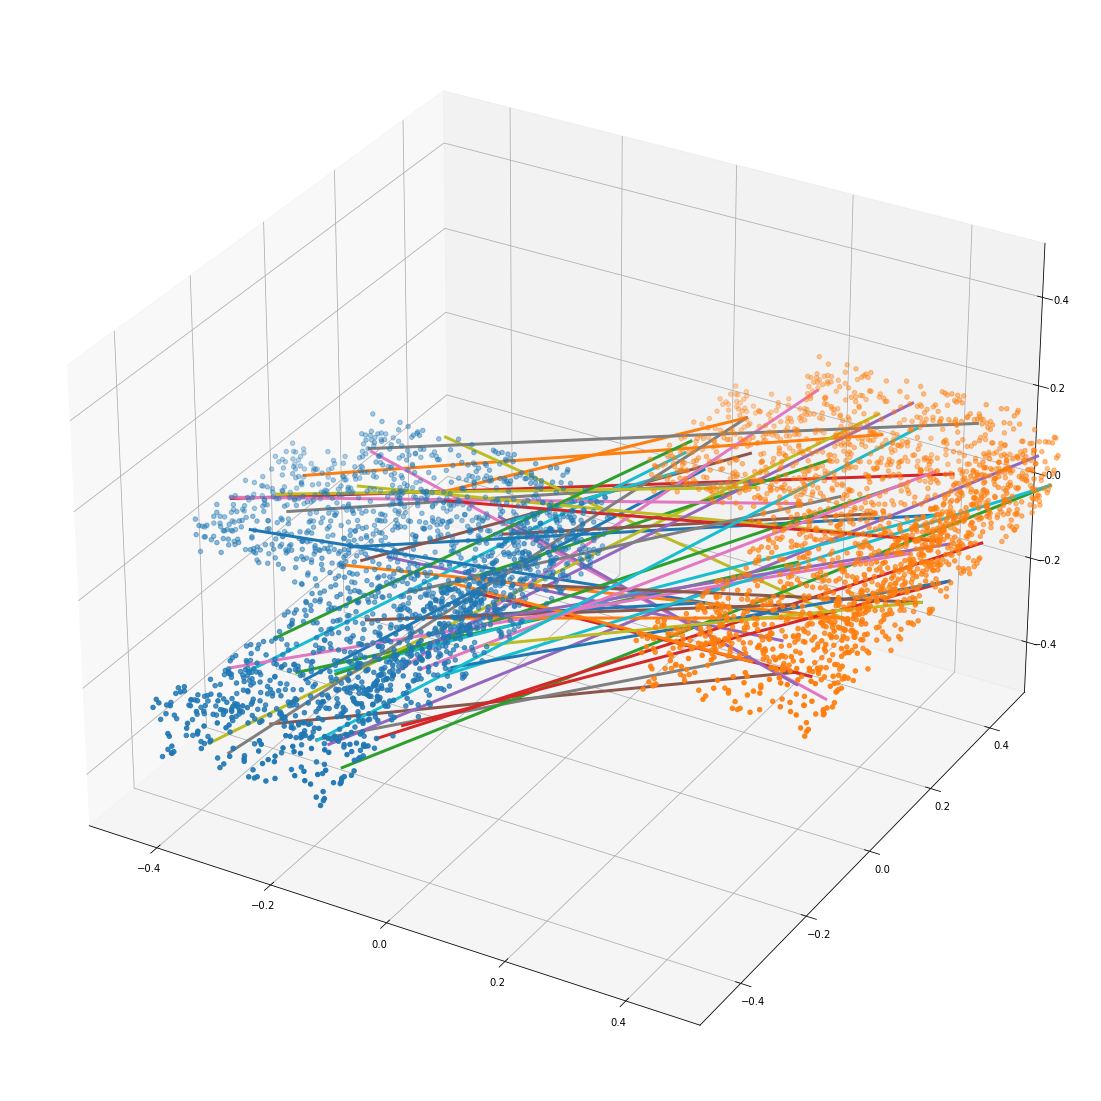

In [28]:
for x,y, centers_idx, cloud in dataset.take(1):
    pass

pred = ppfnet.model(x)
diff = pred[:,:,tf.newaxis] - pred[:,tf.newaxis] # (N, nb_patches, nb_patches, features)
D = tf.reduce_sum(diff*diff, axis=-1) # (N, nb_patches, nb_patches)

idx = 0
matches = np.argsort(D[idx].numpy(), axis=0)[1]

nb_matches = 50
centers_idx_np = centers_idx.numpy()[idx]
idx_start = np.arange(nb_matches)
idx_start = centers_idx_np[idx_start]
idx_end = matches[:nb_matches]
idx_end = centers_idx_np[idx_end]


cloud_np = cloud[idx, 0].numpy()
pos_start = cloud_np[idx_start]
pos_end = cloud_np[idx_end]
delta = np.array([0.25, 0,0.25])
curves = np.stack([pos_start - delta, pos_end + delta], axis=1)

import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(projection='3d')

n= 2000
xs = cloud_np[:n,2]
ys = cloud_np[:n,0]
zs = cloud_np[:n,1]

lim = (-0.5,0.5)

ax.set_xlim(lim)
ax.set_ylim(lim) 
ax.set_zlim(lim) 

ax.scatter(xs-0.25, ys-0.25, zs)
ax.scatter(xs+0.25, ys+0.25, zs)
for i in range(nb_matches):
    ax.plot(curves[:,:,2][i], curves[:,:,0][i], curves[:,:,1][i],linewidth=3)

plt.show()